### Ultramagnet: calculate fields

#### Purpose

To calculate some magneto-seismic properties of the ultramassive white dwarf models and magnetic field evolutions run by Daniel Blatman, in the ultramagnet project.

In [1]:
from qol.seismology.Seismology import Seismology
import qol.mesa.const as const

from astropy.table import Table

import numpy as np
from scipy.interpolate import interp1d

import qol.vis.pyplot as plt

In [2]:
# Define paths
c_o_rundir = '../data/ultramagnet/c_o/main/'
o_ne_rundir = '../data/ultramagnet/o_ne/da/'

c_o_rundir_plus = '../data/ultramagnet/c_o/sigma_3p0/'
c_o_rundir_minus = '../data/ultramagnet/c_o/sigma_m3p0/'

First, read Daniel's files:

In [3]:
def read_ultramagnet_run(field_fname, profile_fname, B0_MG=1, name='', read_age=True):
    """
    Read Daniel Blatman's MESA profiles and magnetic field evolutions

    Bc_MG_init: initial core magnetic field
    """
    # Read data table and make sure they're the same length
    if read_age:
        field_table = Table.read(field_fname, format='ascii', header_start=1)
    else:
        field_table = Table.read(field_fname, format='ascii', header_start=0)
    profile_table = Table.read(profile_fname, format='ascii', header_start=1)

    # Also read age
    if read_age:
        with open(field_fname, 'r') as f:
            text = f.read()
        age = float(text.split('time relative to tcryst: ')[1].split(' years\n')[0])

    # Grab quantities from profile
    R = const.Rsun * profile_table['r']
    N = np.sqrt(np.clip(profile_table['N_squared'], a_min=0, a_max=None))
    Sl1 = np.sqrt(2) * profile_table['c_sound'] / R
    Rho = profile_table['rho']

    # The two files will not have the same radii or even be ordered the same, so interpolate the field onto the profile's grid
    B_div_B0 = interp1d(field_table['r/r_wd'], field_table['B/B0'],
                        kind='linear', fill_value=(field_table['B/B0'][0], field_table['B/B0'][-1]), bounds_error=False)

    B_div_B0_arr = B_div_B0(profile_table['r/r_wd'])
    Br_MG = B0_MG * B_div_B0_arr

    # Create Seismology object
    seismology = Seismology(R=R, N=N, Sl1=Sl1, Rho=Rho, Br_MG=Br_MG)

    # Kludge: dynamically add attributes corresponding to other quantities
    if read_age:
        seismology.age = age
    seismology.B_affect_conv = profile_table['B_crit'] # sqrt(4 pi rho) * v_conv
    seismology.B_suppress_conv = profile_table['B_crit_p'] # sqrt(8 pi p)
    seismology.field_fname = field_fname
    seismology.profile_fname = profile_fname

    seismology.B_div_B0 = B_div_B0_arr

    seismology.one_minus_frac_R = 1 - profile_table['r/r_wd']

    return seismology
    

### *ultramagnet* Figure 2

Shows propagation diagrams and magnetic field profiles.

../data/ultramagnet/c_o/main/table_data_4_matlab.txt 555879.8124291718
../data/ultramagnet/c_o/sigma_3p0/1.22e+03_Myr.txt 165011.3318036307
../data/ultramagnet/c_o/sigma_m3p0/1.06e+03_Myr.txt 1208558.0922336425


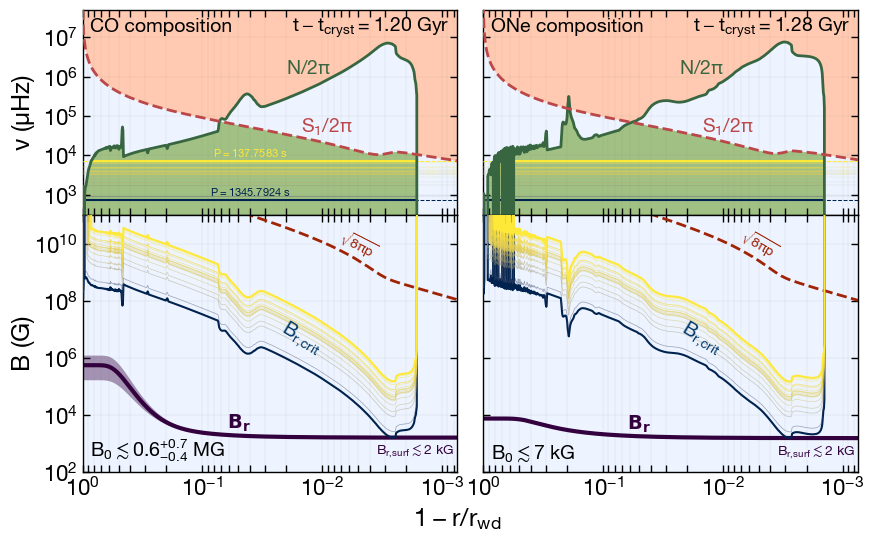

In [6]:
import matplotlib.ticker as ticker

l = 1
B0_MG = 1 # starting internal magnetic field
# P_min, P_max = 137.7583, 1345.7924 # min and max periods of WD J0135, in s

Ps = [1345.7924, 1050.9277, 571.9472, 469.858, 360.0728, 300.1212,
           292.7363, 288.316, 274.3728, 259.976, 253.9881, 253.765,
           234.7436, 206.5939, 194.3922, 192.8621, 158.2864, 147.1648,
           137.7583]
cmap = plt.get_cmap('cividis')

run_infos = []
run_infos.append({'name': 'CO composition',
                  'name2': 'CO',
                 'profile': f'{c_o_rundir}table_data_profile_4.txt',
                 'field': f'{c_o_rundir}table_data_4_matlab.txt',
                 'field+3sig': f'{c_o_rundir_plus}1.22e+03_Myr.txt',
                 'field-3sig': f'{c_o_rundir_minus}1.06e+03_Myr.txt',
                 'gyre_rel_path': 'c_o_gyre/',
                 'input_profile_rel_path': 'profile69.data.GYRE'})
run_infos.append({'name': 'ONe composition',
                  'name2': 'ONe',
                 'profile': f'{o_ne_rundir}table_data_profile_4.txt',
                 'field': f'{o_ne_rundir}table_data_4_matlab.txt',
                 'gyre_rel_path': 'o_ne_gyre/',
                 'input_profile_rel_path': 'profile83.data.GYRE'})

# plt.figure(figsize=(10, 6))
fig, axs = plt.subplots(2, 2, height_ratios=[4, 5], figsize=(10, 6))

X_minlim = 7.5e-4 #2.5e-4 #1.5e-4
alpha_ignore = 0.5
lw_thick = 1.5
lw_thin = 0.5

for ii in range(2):
    run_info = run_infos[ii]
    name = run_info['name']
    profile_fname = run_info['profile']
    field_fname = run_info['field']
    seismology = read_ultramagnet_run(field_fname=field_fname, profile_fname=profile_fname, B0_MG=B0_MG)

    ax = axs[0,ii]
    plt.sca(ax)
    plt.loglog()
    ax.set_xticklabels([])
    plt.xlim(1, X_minlim)
    plt.ylim(3e2, 5e7) #3e7)
    if ii == 0:
        plt.ylabel(r'$\nu$ ($\mu$Hz)')
    else:
        ax.set_yticklabels([])
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=[], numticks=10))

    one_minus_frac_R = seismology.one_minus_frac_R
    N_div_2pi_in_uHz = seismology.N_div_2pi_in_uHz
    Sl_div_2pi_in_uHz = seismology.Sl_div_2pi_in_uHz
    min_N_Sl1_div_2pi_in_uHz = seismology.min_N_Sl1_div_2pi_in_uHz
    max_N_Sl1_div_2pi_in_uHz = seismology.max_N_Sl1_div_2pi_in_uHz

    lw = 3
    plt.plot(one_minus_frac_R, N_div_2pi_in_uHz, c='#386641', ls='-', label='$N/2\pi$', lw=2, zorder=30000)
    plt.plot(one_minus_frac_R, Sl_div_2pi_in_uHz(l), c='#BC4749', ls='--', label=f'$S{l}/2\pi$', lw=2, zorder=30000)
    plt.fill_between(one_minus_frac_R, min_N_Sl1_div_2pi_in_uHz, 1e-10 * min_N_Sl1_div_2pi_in_uHz, color='#A1C084', lw=0, zorder=-np.inf)
    plt.fill_between(one_minus_frac_R, max_N_Sl1_div_2pi_in_uHz, 1e10 * max_N_Sl1_div_2pi_in_uHz, color='#FFCAB1', lw=0, zorder=-np.inf)

    # plot all modes
    for jj, P in enumerate(Ps):
        is_g = seismology.get_is_g(l=1, P=P)
        X_min = np.min(one_minus_frac_R[is_g])
        X_max = np.max(one_minus_frac_R[is_g])

        ν_uHz = 1e6 / P
        c = cmap((np.max(Ps) - P) / (np.max(Ps) - np.min(Ps)))

        if (jj == 0) or (jj+1 == len(Ps)):
            alpha = 1
            lw = lw_thick
        else:
            alpha = alpha_ignore
            lw = lw_thin

        ax.plot([X_min, X_max], 2*[ν_uHz], lw=lw, c=c, zorder=100, alpha=alpha)
        ax.plot([1, X_max], 2*[ν_uHz], lw=0.5*lw, c=c, ls='--', zorder=100, alpha=alpha)
        ax.plot([X_minlim, X_min], 2*[ν_uHz], lw=0.5*lw, c=c, ls='--', zorder=100, alpha=alpha)

    # make text
    ax.corner_text(name, loc='upper left', dx=0.02, dy=0.04)
    ax.corner_text(r'$t-t_{cryst}=' f'{seismology.age/1e9:.2f}$ Gyr', loc='upper right', dx=0.02, dy=0.04-0.01)


    ax = axs[1,ii]
    plt.sca(ax)
    plt.loglog(); plt.xlim(1, X_minlim)
    if ii == 0:
        plt.ylabel(r'$B$ (G)', labelpad=-2)
    else:
        ax.set_yticklabels([])
    # ax.set_xlabel(r'$1-r/R_{wd}$')
    ax.set_ylim(1e2, 1e11)

    for jj, P in enumerate(Ps):
        Bcrit = seismology.get_Bcrit(l=1, P=P, acrit_ref='F+15')
        Bcrit[Bcrit == np.inf] = 1e30


        c = cmap((np.max(Ps) - P) / (np.max(Ps) - np.min(Ps)))

        if (jj == 0) or (jj+1 == len(Ps)):
            alpha = 1
            lw = lw_thick
        else:
            alpha = alpha_ignore
            lw = lw_thin

        ax.plot(one_minus_frac_R, Bcrit, lw=lw, c=c, zorder=100, alpha=alpha)

    # work out B0 needed
    B0 = np.min( seismology.get_Bcrit(l=1, P=np.max(Ps), acrit_ref='F+15') / seismology.B_div_B0 )

    Bsurf = B0 * seismology.B_div_B0[0]

    if 'field+3sig' in run_info.keys():
        field_fname_plus = run_info['field+3sig']
        seismology_plus = read_ultramagnet_run(field_fname=field_fname_plus, profile_fname=profile_fname, B0_MG=B0_MG, read_age=False)
        B0_plus = np.min( seismology_plus.get_Bcrit(l=1, P=np.max(Ps), acrit_ref='F+15') / seismology_plus.B_div_B0 )

        field_fname_minus = run_info['field-3sig']
        seismology_minus = read_ultramagnet_run(field_fname=field_fname_minus, profile_fname=profile_fname, B0_MG=B0_MG, read_age=False)
        B0_minus = np.min( seismology_minus.get_Bcrit(l=1, P=np.max(Ps), acrit_ref='F+15') / seismology_minus.B_div_B0 )

        # plt.plot(seismology.one_minus_frac_R, B0_plus * seismology_plus.B_div_B0, c='xkcd:dark violet', ls='-', label='diffused')
        # plt.plot(seismology.one_minus_frac_R, B0_minus * seismology_minus.B_div_B0, c='xkcd:dark violet', ls='-', label='diffused')

        plt.fill_between(seismology.one_minus_frac_R, B0_plus * seismology_plus.B_div_B0, B0_minus * seismology_minus.B_div_B0, color='xkcd:dark violet', alpha=0.4, lw=0)

        # for CO
        B0_med = B0/1e6
        B0_plusbar = (B0_minus-B0)/1e6
        B0_minusbar = (B0-B0_plus)/1e6

        print(field_fname, B0)
        print(field_fname_plus, B0_plus)
        print(field_fname_minus, B0_minus)

        ax.corner_text(f'$B_0\lesssim{B0_med:.1f}^' r'{+' f'{B0_plusbar:.1f}' r'}' '_' r'{-' f'{B0_minusbar:.1f}' r'}$ MG', loc='lower left', dx=0.02, dy=0.03)

    else:
        ax.corner_text(f'$B_0\lesssim{B0/1e3:.0f}$ kG', loc='lower left', dx=0.02, dy=0.03)

    plt.plot(seismology.one_minus_frac_R, B0 * seismology.B_div_B0, c='xkcd:dark violet', ls='-', label='diffused')

    smallfontsize = 10
    ax.text(X_minlim*1.05, Bsurf/1.5, r'$B_{r,\!surf}' + f'\lesssim{Bsurf/1e3:.0f}$ kG', ha='right', va='top', fontsize=smallfontsize, c='xkcd:dark violet')
    ax.text(5e-2, Bsurf*1.3, r'$\mathbf{B_r}$', ha='center', va='bottom', c='xkcd:dark violet')

    # plot some other fields
    # plt.plot(seismology.one_minus_frac_R, seismology.B_affect_conv, lw=2, c='xkcd:lightish blue', ls=(0, (1, 1, 1, 1)), label=r'$\sqrt{4\pi\rho}v_{conv}$')
    plt.plot(seismology.one_minus_frac_R, seismology.B_suppress_conv, lw=2, c='xkcd:burnt red', ls='--', label=r'$\sqrt{8\pi p}$')



# Start putting text
ax = axs[0,0]
ax.text(1e-2*2, 1.8e6/1.5, r'${N/2\pi}$', c='#386641')
ax.text(1.5e-2, 4e4, r'${S}_1{/2\pi}$', c='#BC4749')
c = cmap(1.0)
ax.text(4e-2, 1e6/np.min(Ps)*1.1, f'$P={np.min(Ps)}$ s', c=c, fontsize=8, va='bottom', ha='center')
c = cmap(0.0)
ax.text(4e-2, 1e6/np.max(Ps)*1.1, f'$P={np.max(Ps)}$ s', c=c, fontsize=8, va='bottom', ha='center')

ax = axs[0,1]
# ax.text(1e-2*2/1.5, 1.8e6, r'${N/2\pi}$', c='#386641')
# ax.text(1.5e-2/1.3, 4e4, r'${S}_1{/2\pi}$', c='#BC4749')
ax.text(1e-2*2*1.15, 1.8e6/1.5, r'${N/2\pi}$', c='#386641')
ax.text(1.5e-2, 4e4, r'${S}_1{/2\pi}$', c='#BC4749')

ax = axs[1,0]
# ax.text(6e-4, 1.1e8, r'$\sqrt{8\pi p}$', c='xkcd:burnt red', ha='center', fontsize=smallfontsize, rotation=-12-6)
# ax.text(6e-4, 2.2e4, r'$\sqrt{4\pi\rho}v_{conv}$', c='xkcd:lightish blue', ha='center', fontsize=smallfontsize)
ax.text(1.5e-2, 1.6e6, r'$B_{r,\!crit}$', c='xkcd:marine blue', ha='center', rotation=-24-7, zorder=2000)

ax = axs[1,1]
# ax.text(1.8e-3, 2e9, r'$\sqrt{8\pi p}$', c='xkcd:burnt red', ha='center', fontsize=smallfontsize, rotation=-14.5-6)
# ax.text(3.5e-4, 3e4, r'$\sqrt{4\pi\rho}v_{conv}$', c='xkcd:lightish blue', ha='center', fontsize=smallfontsize)
# ax.text(1.02e-2, 1.6e6, r'$B_{r,crit}$', c='xkcd:marine blue', ha='center', rotation=-21-7, zorder=2000)
# ax.text(6e-4, 1.1e8, r'$\sqrt{8\pi p}$', c='xkcd:burnt red', ha='center', fontsize=smallfontsize, rotation=-12-6)
# ax.text(6e-4, 2.2e4, r'$\sqrt{4\pi\rho}v_{conv}$', c='xkcd:lightish blue', ha='center', fontsize=smallfontsize)
ax.text(1.5e-2, 1.6e6, r'$B_{r,\!crit}$', c='xkcd:marine blue', ha='center', rotation=-24-7, zorder=2000)

ax = axs[1,0]
Xp = 5e-3
Bp = 3e9
ax.text(Xp, Bp, r'$\sqrt{8\pi p}$', c='xkcd:burnt red', ha='center', fontsize=smallfontsize, rotation=-27)
ax = axs[1,1]
ax.text(Xp, Bp, r'$\sqrt{8\pi p}$', c='xkcd:burnt red', ha='center', fontsize=smallfontsize, rotation=-30)

plt.subplots_adjust(wspace=0.07, hspace=0)

import qol.defaults as defaults
fig.supxlabel(r'$1-r/r_{wd}$', fontsize=defaults.vis_label_size)


plt.savefig('ultramagnet_seismology.pdf')


### *ultramagnet* Figure 3

Shows sensitivity of mode frequencies to magnetic fields.

/Users/nrui/Desktop/pythonpath/qol/seismology/GyreRun.py:185: UserWarning: magnetic_scriptI_nonasympt currently uses a kludge which assumes imaginary part of xi_h is zero. Fine for adiabatic. TODO: generalize this
  warnings.warn('magnetic_scriptI_nonasympt currently uses a kludge which assumes imaginary part of xi_h is zero. Fine for adiabatic. TODO: generalize this')


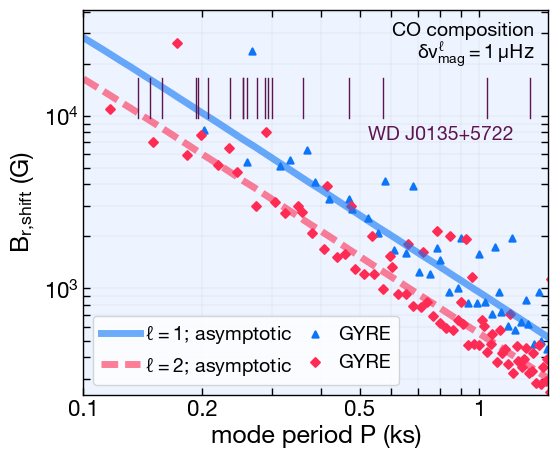

In [14]:
from qol.seismology.GyreRun import GyreRun
import qol.info as info

run_infos = []
run_infos.append({'name': 'CO composition',
                  'name2': 'CO',
                 'profile': f'{c_o_rundir}table_data_profile_4.txt',
                 'field': f'{c_o_rundir}table_data_4_matlab.txt',
                 'field+3sig': f'{c_o_rundir_plus}1.22e+03_Myr.txt',
                 'field-3sig': f'{c_o_rundir_minus}1.06e+03_Myr.txt',
                 'gyre_rel_path': 'c_o_gyre/',
                 'input_profile_rel_path': 'profile69.data.GYRE'})

# Make figure plotting Bshift
νB_uHz = 1 # fixed value

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# ax = plt.gca()
ax.set_xlabel('mode period P (ks)'); ax.set_xscale('log')
ax.set_ylabel(r'$B_{r,\!shift}$ (G)'); ax.set_yscale('log')

# grid to get quantities on
P_ks_grid = np.geomspace(0.1, 1.5)
P_s_grid = 1e3 * P_ks_grid

ax.set_xlim(np.min(P_ks_grid), np.max(P_ks_grid)); ax.set_xscale('log')

for ii in range(1):
    run_info = run_infos[ii]
    name = run_info['name']
    name2 = run_info['name2']
    profile_fname = run_info['profile']
    field_fname = run_info['field']
    seismology = read_ultramagnet_run(field_fname=field_fname, profile_fname=profile_fname, B0_MG=B0_MG)
    gyre_rel_path = run_info['gyre_rel_path']
    input_profile_rel_path = run_info['input_profile_rel_path']

    Brshift_l1 = np.array([])
    Brshift_l2 = np.array([])

    scriptI_l1 = np.array([])
    scriptI_l2 = np.array([])

    use_f_corr_RFH25 = False
    
    for P in P_s_grid:
        val = seismology.get_Brshift_RFH25(νB_uHz=νB_uHz, l=1, P=P, use_f_corr_RFH25=use_f_corr_RFH25)
        Brshift_l1 = np.append(Brshift_l1, val)
        val = seismology.get_Brshift_RFH25(νB_uHz=νB_uHz, l=2, P=P, use_f_corr_RFH25=use_f_corr_RFH25)
        Brshift_l2 = np.append(Brshift_l2, val)

        val = seismology.get_magnetic_scriptI(l=1, P=P, use_f_corr_RFH25=use_f_corr_RFH25)
        scriptI_l1 = np.append(scriptI_l1, val)
        val = seismology.get_magnetic_scriptI(l=2, P=P, use_f_corr_RFH25=use_f_corr_RFH25)
        scriptI_l2 = np.append(scriptI_l2, val)

    # Nonasympt
    gyre_run = GyreRun(gyre_path=f'{info.qol_path}data/ultramagnet/gyre_files/{gyre_rel_path}', input_profile_rel_path=input_profile_rel_path)
    
    ω_arr, Brshift_nonasympt_RFH25_grid_l1 = gyre_run.get_Brshift_nonasympt_RFH25_grid(νB_uHz=νB_uHz, l=1, freq_units='UHZ')
    P_ks_arr_l1 = 2. * const.pi / ω_arr / 1e3

    ω_arr, Brshift_nonasympt_RFH25_grid_l2 = gyre_run.get_Brshift_nonasympt_RFH25_grid(νB_uHz=νB_uHz, l=2, freq_units='UHZ')
    P_ks_arr_l2 = 2. * const.pi / ω_arr / 1e3

    ax.plot(P_ks_grid, Brshift_l1, label='$\ell=1$; asymptotic', alpha=0.6, lw=5)
    ax.plot(P_ks_grid, Brshift_l2, label='$\ell=2$; asymptotic', alpha=0.6, ls=(0, (2.4, 1)), lw=5)
    ax.scatter(P_ks_arr_l1, Brshift_nonasympt_RFH25_grid_l1, label='GYRE', marker='^', s=20) #, label=l1)
    ax.scatter(P_ks_arr_l2, Brshift_nonasympt_RFH25_grid_l2, label='GYRE', marker='D', s=20) #, label=l2)

def format_ticks(value, pos):
    if value <= 0:
        return ''
    power = int(np.floor(np.round(np.log10(value),3)))
    numb = int(np.round(value / 10 ** power))
    if numb in [1, 2, 5]:
        return f'{int(numb) * 10 ** power}'
    
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax.xaxis.set_minor_formatter(ticker.FuncFormatter(format_ticks))

edgescale = 1.3
ax.set_ylim(1e2*np.sqrt(10)/edgescale, edgescale*np.sqrt(10)*1e4)

ax.legend(loc='lower left', ncols=2, columnspacing=0.2, handletextpad=0.2)
ax.corner_text('CO composition', loc='upper right', dy=0.03)
ax.corner_text(r'$\delta\nu_{mag}^\ell=1\,\mu\mathrm{Hz}$', loc='upper right', dy=0.08)


# plot all modes
for P in Ps:
    P_ks = 1e-3 * P

    ax.plot(2*[P_ks], 4*np.array([1e3/1.3, 1e3*1.3]) * np.sqrt(10), c='xkcd:grape purple', lw=1)

ax.text(0.8, 2.3e3 * np.sqrt(10), 'WD J0135+5722', ha='center', c='xkcd:grape purple')


plt.savefig('ultramagnet_frequency_shifts.pdf')